In [1]:
import seaborn as sn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [2]:
df=pd.read_csv('bitcoin.csv')

In [3]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


In [4]:
split=df['Date'].str.split('-',expand=True)
df['Year']=split[0].astype(int)
df['Month']=split[1].astype(int)
df['Day']=split[2].astype(int)

df=df.drop('Date',axis=1)

Text(0, 0.5, 'price of bitcoins')

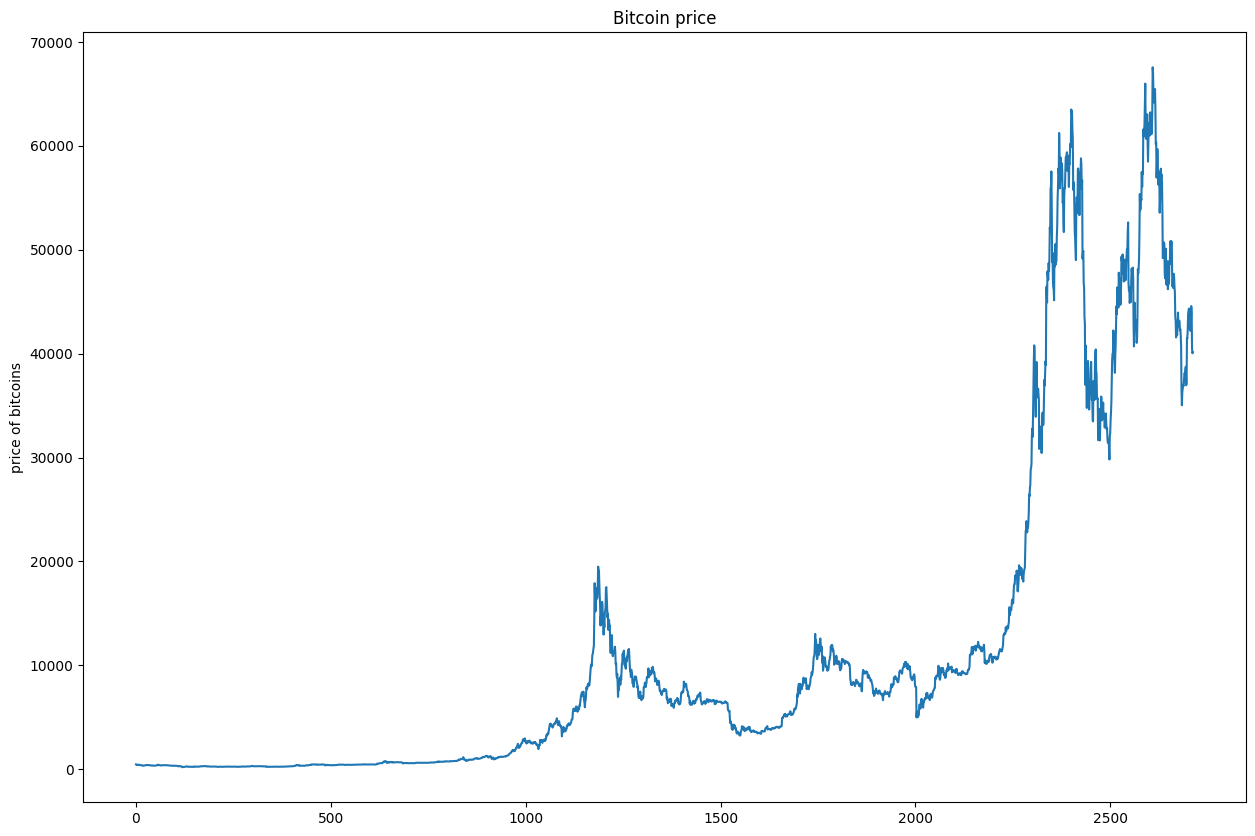

In [5]:
##visualizing the target column (close) variation with time

plt.figure(figsize=(15,10))
plt.plot( df['Close'])
plt.title("Bitcoin price")
plt.ylabel("price of bitcoins")

In [6]:
##deleting redundant data
##adj close has data similar to close

df[df['Close']==df['Adj Close']].shape
df['Close'].shape

##both are same

df = df.drop(['Adj Close'], axis=1)

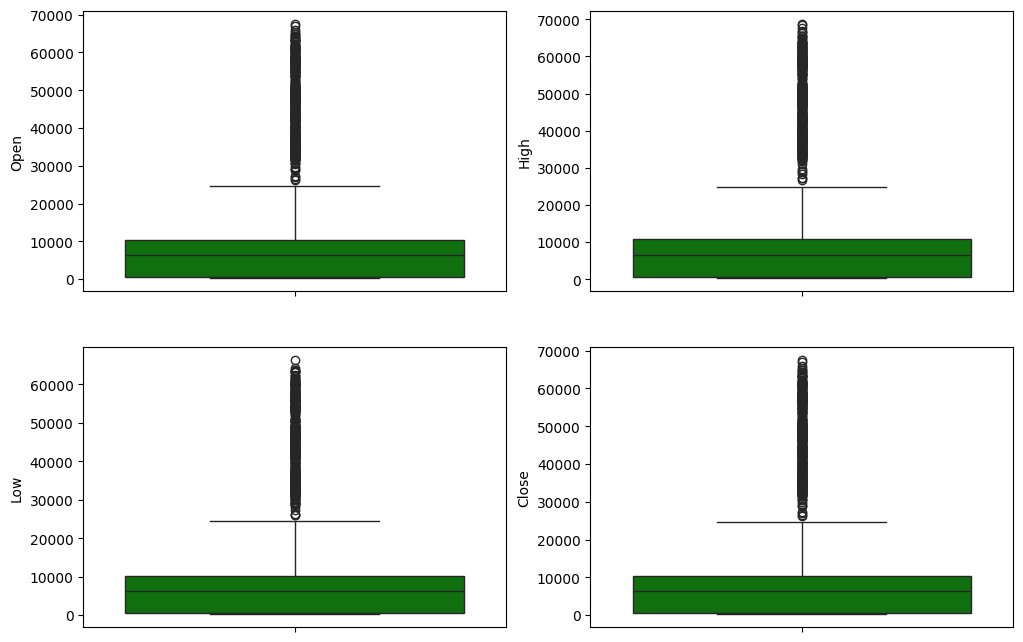

In [7]:
##boxplots

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

features = ['Open', 'High', 'Low', 'Close']

# Plot each boxplot
for i, feature in enumerate(features):
    sn.boxplot(data=df, y=feature, ax=axes[i],color='green')

##### Observation: many outliers in all features.

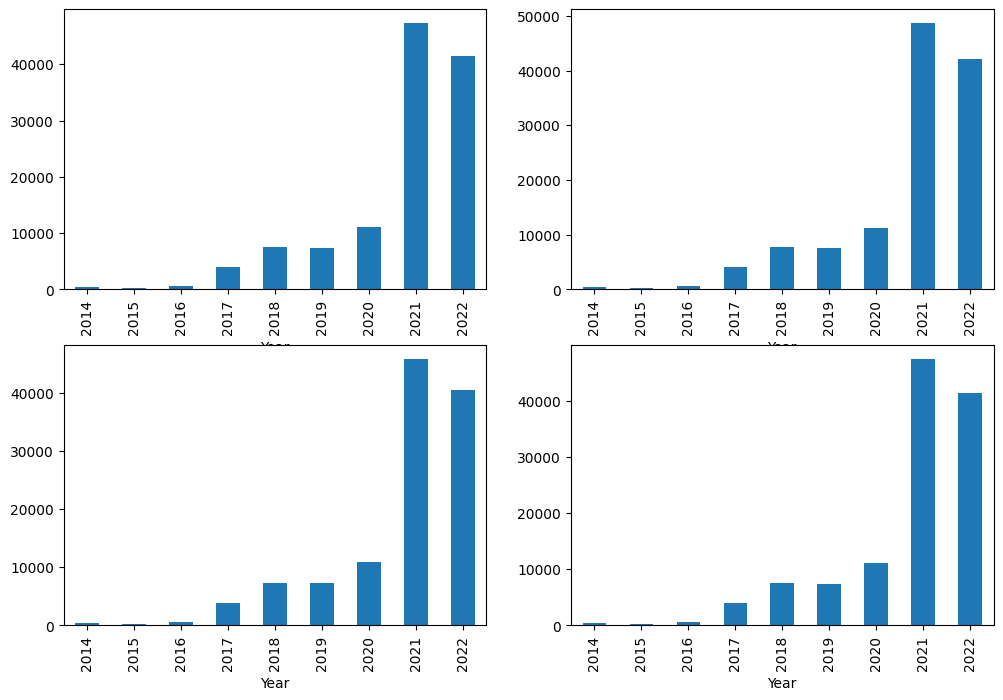

In [8]:
##grouping data by year to see

grouped = df.groupby('Year').mean(numeric_only=True)

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for i, feature in enumerate(features):
    plt.subplot(2,2,i+1)
    grouped[feature].plot.bar()


##### Outliers are mainly after 2021, as indicated by graphs of all features

#### Adding more meaningful data

##### SMA_7-> 7 day simple moving average
##### SMA_30-> 30 day simple moving average
##### EMA_12-> 12 day exponential moving average
##### EMA_26-> 26 day exponential moving average
##### MACD-> moving average convergence divergence

##### 20_MA-> 20 day moving average
##### 20_STD-> 20 day standard deviation
##### Upper band, Lower band-> if out of this range, possibly overbought or oversold respectively

##### RSI-> it is the ratio of the average gain and average loss in a 14 day window. If RSI>70, overbought. RSI<30, oversold


In [9]:
# Add more meaningful technical indicators
df['SMA_7'] = df['Close'].rolling(window=7).mean()  # 7-day simple moving average
df['SMA_30'] = df['Close'].rolling(window=30).mean() # 30-day SMA
df['EMA_12'] = df['Close'].ewm(span=12, adjust=False).mean() # Exponential MA
df['EMA_26'] = df['Close'].ewm(span=26, adjust=False).mean()
df['MACD'] = df['EMA_12'] - df['EMA_26'] # Moving Average Convergence Divergence

# Bollinger Bands
df['20_MA'] = df['Close'].rolling(window=20).mean()
df['20_STD'] = df['Close'].rolling(window=20).std() 
df['Upper_Band'] = df['20_MA'] + (df['20_STD'] * 2)
df['Lower_Band'] = df['20_MA'] - (df['20_STD'] * 2)

# RSI (Relative Strength Index)
delta = df['Close'].diff(1)
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()
rs = avg_gain / avg_loss
df['RSI'] = 100 - (100 / (1 + rs))

# Drop NA values from rolling calculations
df.dropna(inplace=True)

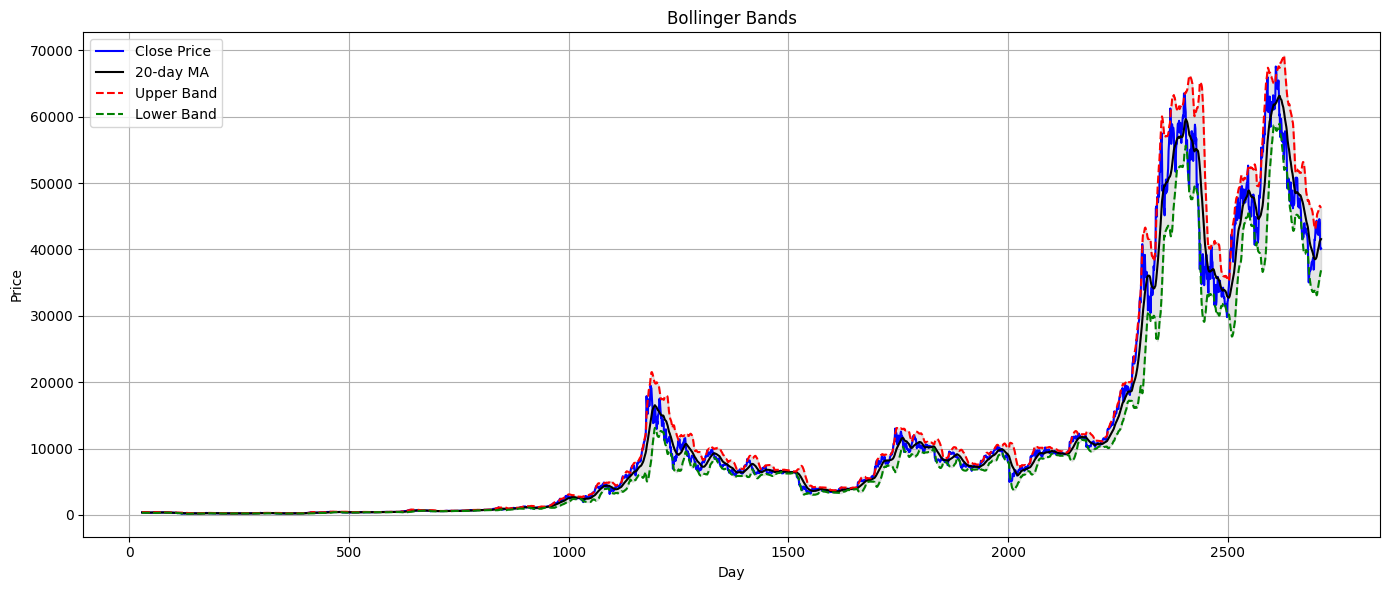

In [10]:
# Plot
plt.figure(figsize=(14, 6))
plt.plot(df['Close'], label='Close Price', color='blue')
plt.plot(df['20_MA'], label='20-day MA', color='black')
plt.plot(df['Upper_Band'], label='Upper Band', color='red', linestyle='--')
plt.plot(df['Lower_Band'], label='Lower Band', color='green', linestyle='--')
plt.fill_between(df.index, df['Lower_Band'], df['Upper_Band'], color='gray', alpha=0.2)
plt.title("Bollinger Bands")
plt.xlabel("Day")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#### 1. Wide Bands during Major Spikes

##### Whenever there's a rapid surge (e.g., ~index 1200 and 2400), the bands expand significantly — indicating high volatility.

#### 2. Narrow Bands in Flat Zones

##### In earlier parts of the chart (left side), the bands are tight — suggesting low volatility or consolidation periods.

#### 3. Touching Upper/Lower Bands

##### Price nearing the upper band → possibly overbought
##### Price nearing the lower band → possibly oversold

In [11]:
# Approach 1: Future price movement
df['Target'] = (df['Close'].shift(-5) > df['Close']).astype(int)  # Will price go up in next 5 days?

# Approach 2: Based on technical indicators
df['Target'] = ((df['Close'] > df['Upper_Band']) | (df['RSI'] > 70)).astype(int)  # Overbought signal

# Approach 3: Percentage change threshold
future_pct_change = df['Close'].pct_change(5).shift(-5)
df['Target'] = (future_pct_change < -0.05).astype(int)  # Will price drop >5% in next 5 days?

##### Can use two more approaches: 
##### Approach 2: Based on technical indicators
df['Target'] = ((df['Close'] > df['Upper_Band']) | (df['RSI'] > 70)).astype(int)  # Overbought signal

##### Approach 3: Percentage change threshold
future_pct_change = df['Close'].pct_change(5).shift(-5)
df['Target'] = (future_pct_change < -0.05).astype(int)  # Will price drop >5% in next 5 days?

In [12]:
# Time-based split (don't use random split)
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

In [13]:
from xgboost import XGBClassifier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import classification_report, accuracy_score

# Define features and target
features = ['Open', 'High', 'Low', 'Close', 'Volume', 'SMA_7', 'SMA_30', 
           'MACD', 'RSI', 'Upper_Band', 'Lower_Band']
X = df[features]
y = df['Target']

# Time-series cross-validation
tscv = TimeSeriesSplit(n_splits=5)

for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    model = XGBClassifier(
        objective='binary:logistic',
        n_estimators=1000,
        learning_rate=0.01,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        early_stopping_rounds=50,
        eval_metric='logloss'
    )
    
    model.fit(X_train, y_train, 
             eval_set=[(X_test, y_test)],
             verbose=False)
    
    preds = model.predict(X_test)
    print(classification_report(y_test, preds))
    print("Accuracy:", accuracy_score(y_test, preds))

/opt/anaconda3/envs/gugu/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/gugu/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/gugu/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaco

              precision    recall  f1-score   support

           0       0.89      1.00      0.94       398
           1       0.00      0.00      0.00        49

    accuracy                           0.89       447
   macro avg       0.45      0.50      0.47       447
weighted avg       0.79      0.89      0.84       447

Accuracy: 0.8903803131991052
              precision    recall  f1-score   support

           0       0.73      1.00      0.84       325
           1       0.00      0.00      0.00       122

    accuracy                           0.73       447
   macro avg       0.36      0.50      0.42       447
weighted avg       0.53      0.73      0.61       447

Accuracy: 0.727069351230425


/opt/anaconda3/envs/gugu/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/gugu/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/gugu/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaco

              precision    recall  f1-score   support

           0       0.79      1.00      0.89       355
           1       0.00      0.00      0.00        92

    accuracy                           0.79       447
   macro avg       0.40      0.50      0.44       447
weighted avg       0.63      0.79      0.70       447

Accuracy: 0.7941834451901566
              precision    recall  f1-score   support

           0       0.86      1.00      0.93       385
           1       0.00      0.00      0.00        62

    accuracy                           0.86       447
   macro avg       0.43      0.50      0.46       447
weighted avg       0.74      0.86      0.80       447

Accuracy: 0.8612975391498882
              precision    recall  f1-score   support

           0       0.76      1.00      0.86       340
           1       0.00      0.00      0.00       107

    accuracy                           0.76       447
   macro avg       0.38      0.50      0.43       447
weighted avg    

/opt/anaconda3/envs/gugu/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/gugu/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/gugu/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
